# **Tutorial 3: Visualizing satellite CDR - Global Vegetation Mapping**

**Week 1, Day 3, Remote Sensing**

**Content creators:** Douglas Rao

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In this tutorial, you will acquire skills necessary for accessing and analyzing satellite remote sensing products, particularly in the context of climate applications. We will be using vegetation mapping as an example and use the long-term vegetation greeness data to demonstrate these skills.

By the end of this tutorial you will be able to:

* Locate, access, and visualize vegetation greeness data (NDVI) from cloud using `xarray` and `matplotlib`.
* Understand how to use quality flag information from remote sensing dataset to filter data that is proper for climate analysis.


# **Setup**



In this section, we have:


1.   **Import cell:** imports all libraries you use in the tutorial.
2.   **Hidden Figure settings cell:** sets up the plotting style (copy exactly)
1.   **Hidden Plotting functions cell:** contains all functions used to create plots throughout the tutorial (so students don't waste time looking at boilerplate matplotlib but can here if they wish to). Please use only matplotlib for plotting for consistency.
2.   **Hidden Helper functions cell:** This should contain functions that students have previously used or that are very simple. Any helper functions that are being used for the first time and are important should be placed directly above the relevant text or exercise (see Section 1.1 for an example).
    



In [1]:
# google colab installs

# !pip install s3fs --quiet
# !pip install cartopy --quiet



In [1]:
#Imports

import s3fs
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime
import boto3
import botocore
import pooch


In [2]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

# **Section 1: Satellite Monitoring of Vegetation Status**

As we learned in the previous tutorial, all NOAA CDR datasets are available both at NOAA NCEI and commercial cloud platforms. Here, we are accessing the data directly via Amazon Web Service (AWS). You can find out the NOAA CDR data on AWS's Open Data Registry.

* [NOAA Fundamental CDR on AWS](https://registry.opendata.aws/noaa-cdr-fundamental/) 
* [NOAA Terrestrial CDR on AWS](https://registry.opendata.aws/noaa-cdr-terrestrial/) 
* [NOAA Atmospheric CDR on AWS](https://registry.opendata.aws/noaa-cdr-atmospheric/) 
* [NOAA Oceanic CDR on AWS](https://registry.opendata.aws/noaa-cdr-oceanic/) 



In [3]:
# @title Video 1: Video 1 Name
#Tech team will add code to format and display the video

**Normalized Difference Vegetation Index (NDVI)** is one of the most commonly used remotely sensed indices to measure the "greeness" of vegetation and is useful in understanding vegetation density and assessing changes in plant health. NDVI can be used to study the impact of drought, heatwave, and insect infestation on the plants at scale.

## **Section 1.1: Access NOAA NDVI CDR Data from AWS**



If we go to the [cloud storage space (or a S3 bucket)](https://noaa-cdr-ndvi-pds.s3.amazonaws.com/index.html#data/) that host NOAA NDVI CDR data, you can find the pattern of how the NOAA NDVI CDR is stored:

`s3://noaa-cdr-ndvi-pds/data/1981/AVHRR-Land_v005_AVH13C1_NOAA-07_19810624_c20170610041337.nc`

There is a pattern on how the data is organized. We can take advantage of the pattern to search for the data file programaticaly. 

> Parent directory: `s3://noaa-cdr-ndvi-pds/data/`  
> Sub-directory for each year: `1981/`  
> File name of each day: `AVHRR-Land_v005_AVH13C1_NOAA-07_19810624_c20170610041337.nc`

The file name also has a clear pattern:

> Sensor name: `AVHRR`  
> Product category: `Land`  
> Product version: `v005`  
> Product code: `AVH13C1`  
> Satellite platform: `NOAA-07`  
> Date of the data: `19810624`  
> Processing time: `c20170610041337` (*This will change for each file based on when the file are processed*)  
> File format: `.nc` (*netCDR-4 format*)

In other words, if we are looking for the data of a specific day, we can easily locate where the file might be. 

For example, if we want to find the AVHRR data for the day of *2002-03-12 (or March 12, 2002)*, we will be looking at something like this:

`s3://noaa-cdr-ndvi-pds/data/2002/AVHRR-Land_v005_AVH13C1_*_20020312_c*.nc`

The reasaon that we put `*` in the above directory is because we are not sure about what satellite platform this data is from and when the data is being processed. But with this pattern we can still check if the file exist.





In [4]:
# To access the NDVI data from AWS S3 bucket, we first need to connect to s3 bucket
fs = s3fs.S3FileSystem(anon=True)

# We can now check to see if the file exist in this cloud storage bucket using the
# file name pattern we just described
date_sel = datetime.datetime(2002,3,12,0) # select a desired date and hours (midnight is zero)

# automatic filename from data_sel. we use strftime (string format time) to get the text format of the file in question. 
file_location = fs.glob('s3://noaa-cdr-ndvi-pds/data/'+
                        date_sel.strftime('%Y')+'/AVHRR-Land_v005_AVH13C1_*'+
                        date_sel.strftime('%Y%m%d')+'_c*.nc')
# Now let's check if there is a file match the pattern of the date that we are
# interested in.
file_location

['noaa-cdr-ndvi-pds/data/2002/AVHRR-Land_v005_AVH13C1_NOAA-16_20020312_c20170321233653.nc']

### **Code exercise 1.1: Finding the data of your interest**

Looks like we find the daily data that we are looking for earlier. Can you try to find the data of a specific date that you want to check?

**Hint:** NDVI CDR data switched sensors on 2014 from AVHRR (the older generation sensor) to VIIRS (the newest generation sensor). So if you are trying to find the data after 2013, you may want to adjust the code to locate the data properly.

In [5]:
################################################################################
## Choose a data of your interest and identify the location of the NDVI CDR   ##
## data on Amazon Web Service                                                 ##
################################################################################
# exercise_file = fs.glob(...)
# print(exercise_file)

# Ohad comment: this exercise is now pointless. they only have to change the datetime parameters in the cell above. 
# the code does the rest with strftime does the rest - they have seen it before, in W1D2 already


## **Section 1.2: Read NDVI CDR Data**

Now we have the location of the NDVI data for a specific date. We can read in the data using the python library `xarray` to open the netCDF-4 file, a common data format used to store satellite and climate datasets.



In [7]:
## First, we need to open the connection to the file object of the selected date.
## We are still using the date of 2002-03-12 as the example here.

# to keep up with previous tutorials (consisteny), we are going to use boto3 and pooch to open the file. 
# note the s3fs also has the ability to open files from s3 remotly.  

client = boto3.client('s3', config=botocore.client.Config(signature_version=botocore.UNSIGNED)) # initialize aws s3 bucket client

ds = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location[0],known_hash=None )) # open the file
ds 

/Users/chi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:    (latitude: 3600, longitude: 7200, time: 1, ncrs: 1, nv: 2)
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12
Dimensions without coordinates: ncrs, nv
Data variables:
    crs        (ncrs) int16 ...
    lat_bnds   (latitude, nv) float32 ...
    lon_bnds   (longitude, nv) float32 ...
    NDVI       (time, latitude, longitude) float32 ...
    TIMEOFDAY  (time, latitude, longitude) datetime64[ns] ...
    QA         (time, latitude, longitude) int16 ...
Attributes: (12/48)
    title:                                  Normalized Difference Vegetation ...
    institution:                            NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-...
    Conventions:                            CF-1.6, ACDD-1.3
    standard_name_vocabulary:               CF Standard Name Table (v25, 05 J...
    naming_authority:                       gov.noaa.ncei
    license:                                See the Use Agreement for this CD...
    ...                                     ...
    PercentValidDaytimeData:                34.50
    PercentValidDaytimeLand:                34.50
    PercentValidClearDaytimeLand:           4.42
    PercentValidDaytimeLandInCloudShadow:   0.90
    PercentValidClearDaytimeWater:          0.00
    PercentValidDaytimeWaterInCloudShadow:  0.00

The output from the code block tells us that the NDVI data file of 2002-03-12 has the dimention of `3600x7200`. This makes sense for a dataset with the spatial resolution of 0.5°×0.5°. There is another dimension of the dataset named `time`. Since it is a daily data file, it only contains one value in its dimension.

Two main data variables in this dataset are `NDVI` and `QA`.

* `NDVI` is the variable that contains the value of NDVI (ranges between -1 and 1) that can be used to measure the vegetation greeness.  
* `QA` is the variable that indicates the quality of the NDVI values for each corresponding grid. It reflects whether the data is of high quality or should be discarded because of various reasons (e.g., bad sensor data, potentially contanminated by cloud).



## **Section 1.3: Visualize NDVI CDR Data**

In [8]:
## Now let's only looking at the NDVI values from the dataset
ndvi = ds.NDVI
ndvi

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

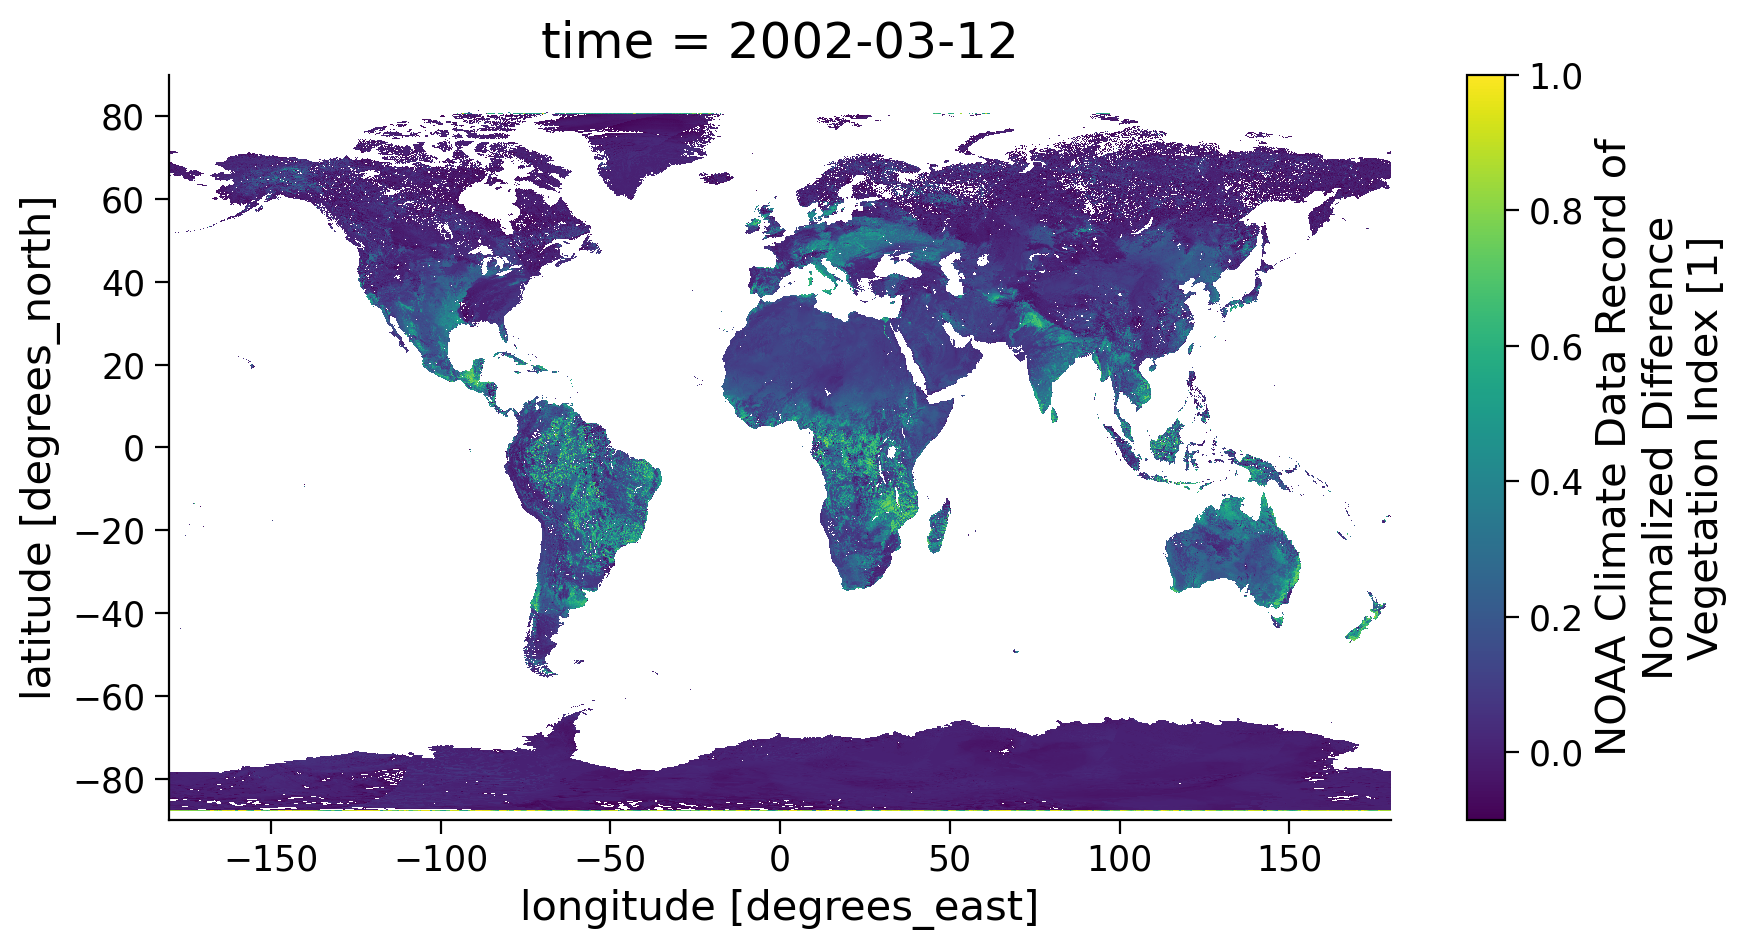

In [10]:
## As this is a gridded dataset, we can plot the data of this day directly to
## visually understand the data.

## Figure settings:
## vmin & vmax: minimum and maximum values for the legend
## aspect: setting the aspect ratio of the figure, must be combined with `size`
## size: setting the overall size of th figure

ndvi.plot(vmin=-0.1, vmax=1.0, aspect=1.8, size=5)

## **Section 1.4: Mask NDVI Data Using Quality Flag**

As stated earlier, there is also a variable `QA` that indicates the quality of the NDVI value for each grid cell. This quality information is very important when using satellite data to ensure the climate analysis is only done using the highest quality data that are appropirate for the application.

For NDVI CDR data, it has a complex quality flag system that is represented using 16-bit system. Although when you reach in the `QA`, it appears to be normal numeric values, the QA value needs to be converted to binary values of 16 bits and recognize the quality flag based on the information listed in the table below. 

| Bit No. | Description | Value=1 | Value=0 |
|-:|:-|:-:|:-:|
|15|Flag to indicate if the pixel is in polar region|Yes|No|
|14|Flag to indicate BRDF-correction issues|Yes|No|
|13|Flag to indicate RH03 value is invalid|Yes|No|
|12|Flag to indicate AVHRR Channel 5 value is invalid|Yes|No|
|11|Flag to indicate AVHRR Channel 4 value is invalid|Yes|No|
|10|Flag to indicate AVHRR Channel 3 value is invalid|Yes|No|
| 9|Flag to indicate AVHRR Channel 2 value is invalid|Yes|No|
| 8|Flag to indicate AVHRR Channel 1 value is invalid|Yes|No|
| 7|Flag to indicate all 5 AVHRR Channels are valid|Yes|No|
| 6|Flag to indicate the pixel is at night (no visible channel data)|Yes|No|
| 5|Flag to indicate the pixel is over dense dark vegetation|Yes|No|
| 4|Flag to indicate the pixel is over sunglint (over ocean)|Yes|No|
| 3|Flag to indicate the pixel is over water|Yes|No|
| 2|Flag to indicate the pixel contains cloud shadow|Yes|No|
| 1|Flag to indicate the pixel is cloudy|Yes|No|
| 0|(Unused)|Yes|No|

This shows the complex system to ensure that satellite CDR data is of high quality for climate applications. But how can we decifer the quality of a given pixel? 

Assuming that we have a grid with `QA=18`, when converted into binary value with the length of 16 bits is `0000000000010010`. So it can be interpreted as

|Bit15|Bit14|Bit13|Bit12|Bit11|Bit10|Bit9|Bit8|Bit7|Bit6|Bit5|Bit4|Bit3|Bit2|Bit1|Bit0|
|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|-:|
|0|0|0|0|0|0|0|0|1|0|0|1|0|0|1|0|
|No|No|No|No|No|No|No|No|Yes|No|No|Yes|No|No|Yes|No|

This means that the NDVI of the value is retrieved from valid values of AVHRR channels (`Bit7=1`) and the grid is over dense dark vegetation (`Bit5=1`), but the gird is cloudy (`Bit1=1`). Therefore, the QA tells us that we should not use this grid since it is covered the by cloud and cannot reflect the vegetation information on the land surface. 

Now let's define a function to create the cloud mask.

In [11]:
#@markdown *Run this cell to define the function to extract high quality NDVI data `get_quality_info()`*
def get_quality_info(QA):
  """
  QA: the QA value read in from the NDVI data

  High quality NDVI should meet the following criteria:
  Bit 7: 1 (All AVHRR channels have valid values)
  Bit 2: 0 (The pixel is not covered by cloud shadow)
  Bit 1: 0 (The pixel is not covered by cloud)

  Output:
  True: high quality
  False: low quality
  """
  ## Unpack quality assurance flag for cloud (byte: 1)
  cld_flag = (QA % (2**2)) // 2;
  ## Unpack quality assurance flag for cloud shadow (byte: 2)
  cld_shadow = (QA % (2**3)) // 2**2;
  ## Unpack quality assurance flag for AVHRR values (byte: 7)
  value_valid = (QA % (2**8)) // 2**7;

  mask = (cld_flag == 0) & (cld_shadow == 0) & (value_valid ==1)

  return mask

In [12]:
#@markdown *Run this cell to extract the mask indicates high quality NDVI grid using `get_quality_info()`*

## Get the quality assurance value from NDVI data
QA = ds.QA
## Create the high quality information mask
mask = get_quality_info(QA)
## Check the quality flag mask information
mask

<xarray.DataArray 'QA' (time: 1, latitude: 3600, longitude: 7200)>
array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12

The output of the previous operation gives us a data array with logical values to indicate if a grid has high quality NDVI values or not. Now let's mask out the NDVI data array with this quality information to see if this will make a difference in the final map.

In [13]:
#@markdown Run this cell to use `.where` to only keep the NDVI values with high quality flag.
ndvi_masked = ndvi.where(mask)
ndvi_masked

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2002-03-12
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

As you may have noticed, a lot of the NDVI values in the masked data array becomes `nan` which means `not a number`. This means that the grid does not have a high quality NDVI value based on the QA value. Now, let's plot the map one more time to see the difference after the quality masking.

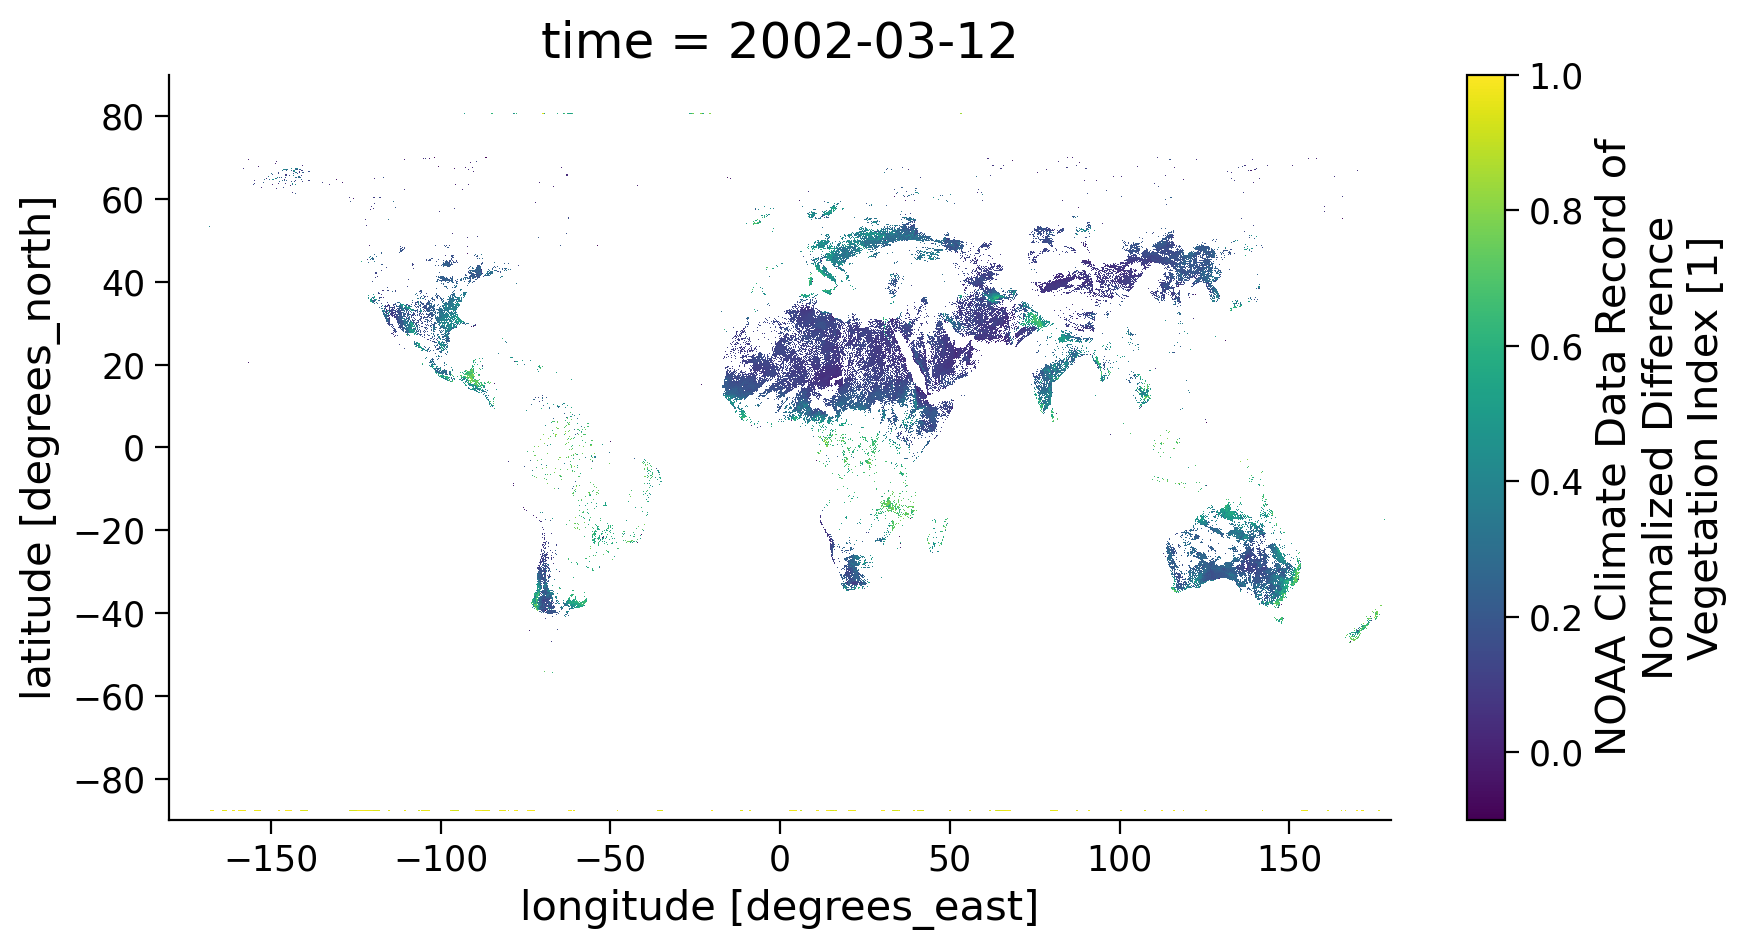

In [14]:
#@markdown Run this cell to re-plot the NDVI map using masked data
ndvi_masked.plot(vmin = -0.1, vmax = 1.0, aspect=1.8, size=5)

You can clearly see the difference after the quality mask for NDVI value. This is largely because of the cloud effect. Since NDVI value is calculated using the reflectance values of the red and near-infrared spectral band, this value is only useful for vegetation and surface monitoring when there is no cloud present. Thus, we always need to remove the grid with cloud in the data.

### **Code Exercise 1.4: Read and Visualize the NDVI data of your choice**

Now we learned how to use `xarray` and `matplotlib` to access NDVI CDR data from AWS and visualize it. Can you find a different date that you are interested in and visualize the high quality NDVI data of that day?

In [22]:
### Step 1: Define the date of your interest YYYYMMDD (e.g., 20030701)

### Step 2: Locate the data in the AWS S3 bucket
### Hint: use the file pattern that we described

### Step 3: Open file connection to the file in AWS S3 bucket
### Hint: use s3fs to open the connection

### Step 4: Use xarray to open the NDVI CDR file
### Hint: use xarry open_dataset

### Step 5: Get the QA value and extract the high quality data mask
### Hint: reuse the get_quality_info helper function we defined

### Step 6: Mask NDVI data to keep only high quality value
### Hint: use the quality info flag

### Step 7: Plot high quality NDVI data
### Hint: use plot() function

SHA256 hash of downloaded file: 22b3b91a69eaa7ae81a19eae2a6682b8b4a3d711a72e7ab5ab924967f1e422b8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
/Users/chi/miniconda3/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


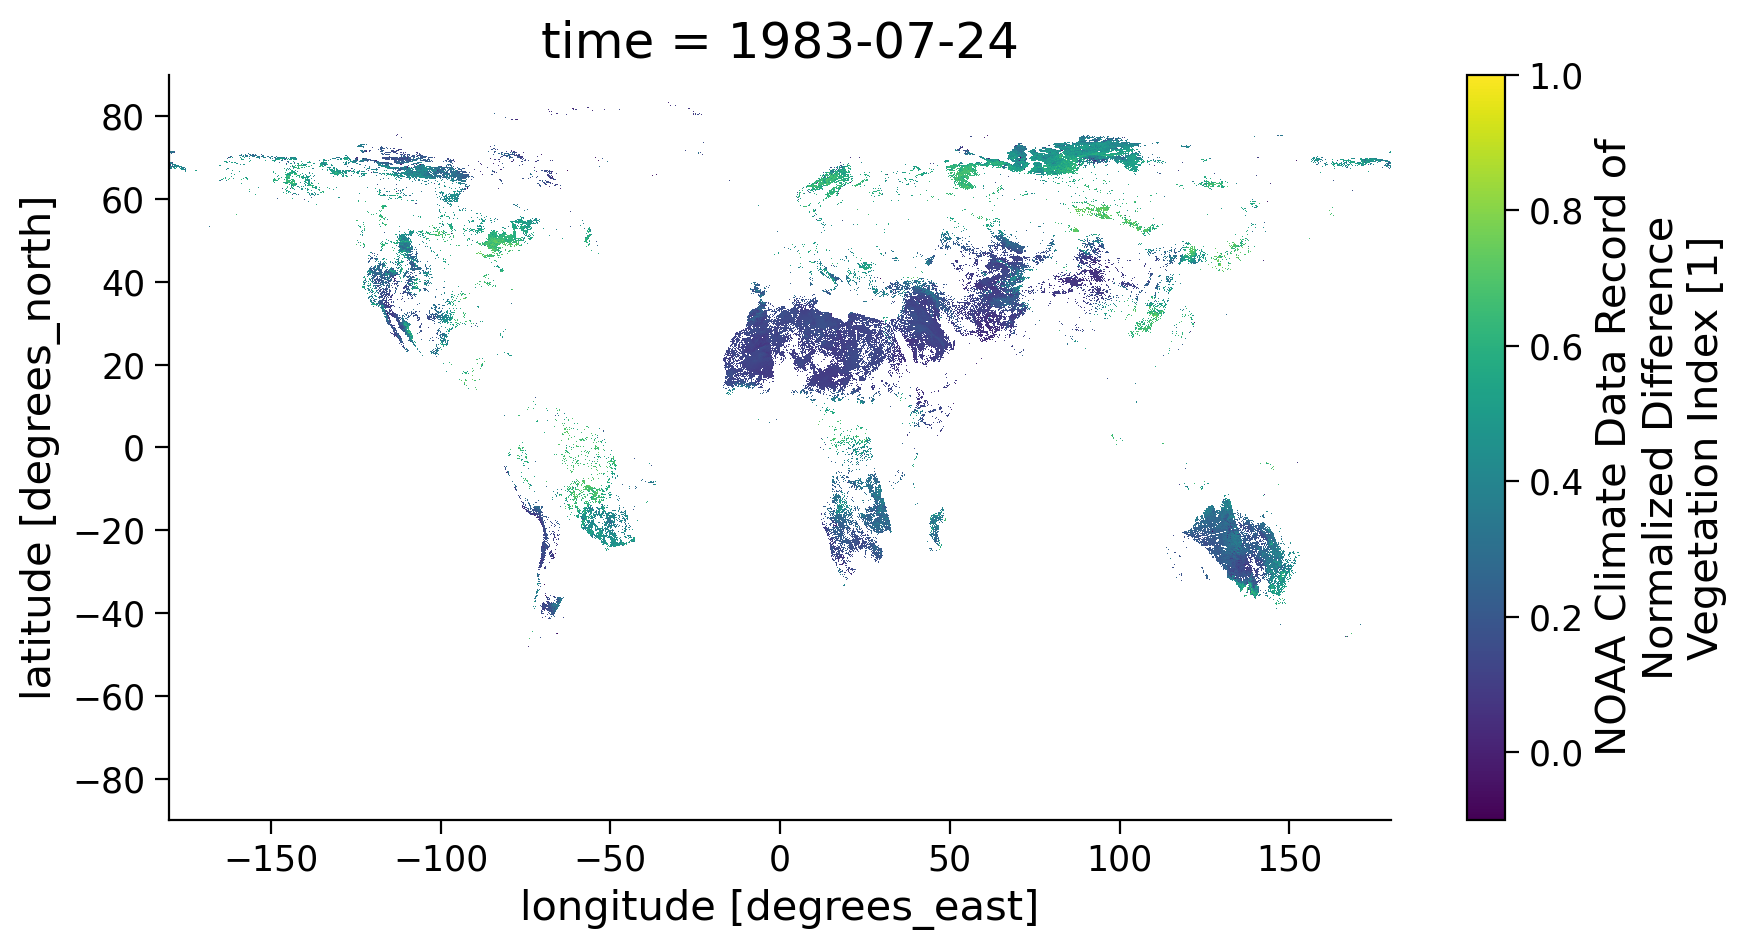

In [15]:
## to remove solution
### Step 1: Define the date of your interest YYYYMMDD (e.g., 20030701)
date_sel_exercise = datetime.datetime(1983,7,24,0) # select a desired date and hours (midnight is zero)

### Step 2: Locate the data in the AWS S3 bucket
### Hint: use the file pattern that we described
file_location_exercise = fs.glob('s3://noaa-cdr-ndvi-pds/data/'+
                        date_sel_exercise.strftime('%Y')+'/AVHRR-Land_v005_AVH13C1_*'+
                                 date_sel_exercise.strftime('%Y%m%d')+'_c*.nc')

### Step 3 + 4 : Open file connection to the file in AWS S3 bucket and Use xarray to open the NDVI CDR file
### Hint: use s3fs to open the connection
ds_exercise = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location_exercise[0],known_hash=None )) # open the file


### Step 5+6: Get the QA value and extract the high quality data mask and Mask NDVI data to keep only high quality value
### Hint: reuse the get_quality_info helper function we defined
ndvi_masked_exercise = ds_exercise.NDVI.where(get_quality_info(ds_exercise.QA))

### Step 7: Plot high quality NDVI data
### Hint: use plot() function
ndvi_masked_exercise.plot(vmin = -0.1, vmax = 1.0, aspect=1.8, size=5)

# **Summary**

In this tutorial, you successfully accessed and visualized one of the most commonly used remotely sensed climate dataset for land applications! This is an important first step to the climate analysis. Please make sure you

* Understand the file organization pattern to help you identify the data that you are interested in.
* Understand the dataset, particularly the quality information, to only use the proper dataset for your analysis.
* Remotely sensed data often have user guider or algorithm document that will provide detailed information of the dataset.

In next tutorial, we will explore how to perform time series analysis, including calculating climatology and anomaly with precipitation data.
